In [1]:
'''
This notebook uses Long Short-Term Memory (LSTM) on multivariate time series data to predict the closing 
stock price of a corporation using the past 60 day stock movement.

https://www.crosstab.io/articles/time-series-pytorch-lstm/ code in this article is used for reference
'''
# Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
plt.style.use('fivethirtyeight')

# Get cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the past stock price
# today's date
today = pd.to_datetime('today').strftime('%Y-%m-%d')
# 5 year ago
start = pd.to_datetime('today') - pd.DateOffset(years=2)
df = web.DataReader('AAPL', data_source='yahoo', start=start, end=today)

In [3]:
#df.drop(['Volume'],axis=1,inplace=True)

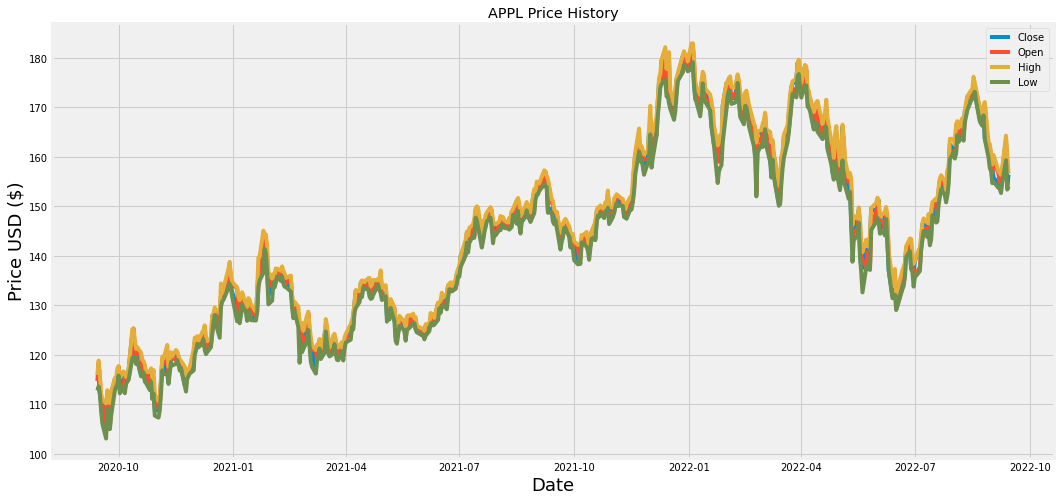

In [4]:
#plot the data
plt.figure(figsize=(16,8))
plt.title('APPL Price History')
plt.plot(df['Close'], label="Close")
plt.plot(df['Open'], label="Open")
plt.plot(df['High'], label="High")
plt.plot(df['Low'], label="Low")

plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

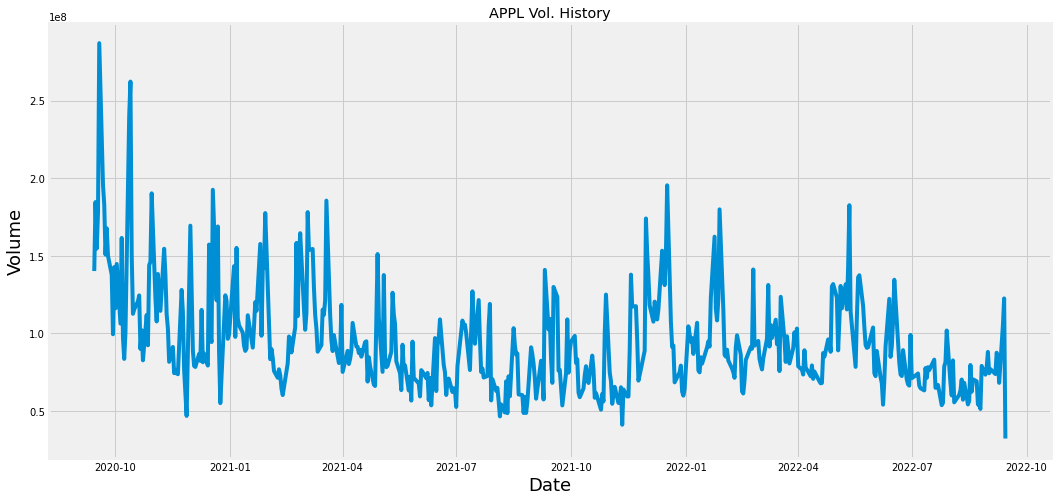

In [5]:
plt.figure(figsize=(16,8))
plt.title('APPL Vol. History')
plt.plot(df['Volume'], label="Volume")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume', fontsize=18)
plt.show

In [6]:
# prepare data
target_data = "Close"
feature = list(df.columns.difference([target_data]))

forecast_lead = 1
target = f"{target_data}_t+{forecast_lead}"

df[target] = df[target_data].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

# split data
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_df, test_df = df.iloc[0:train_size].copy(), df.iloc[train_size:len(df)].copy()

In [7]:
test_df

,High,Low,Open,Close,Volume,Adj Close,Close_t+1
Date,,,,,,,
2022-04-20,168.880005,166.100006,168.759995,167.229996,67929800.0,166.753021,166.419998
2022-04-21,171.529999,165.910004,168.910004,166.419998,87227800.0,165.945328,161.789993
2022-04-22,167.869995,161.500000,166.460007,161.789993,84882400.0,161.328537,162.880005
2022-04-25,163.169998,158.460007,161.119995,162.880005,96046400.0,162.415436,156.800003
2022-04-26,162.339996,156.720001,162.250000,156.800003,95623200.0,156.352783,156.570007
...,...,...,...,...,...,...,...
2022-09-07,156.669998,153.610001,154.820007,155.960007,87449600.0,155.960007,154.460007
2022-09-08,156.360001,152.679993,154.639999,154.460007,84923800.0,154.460007,157.369995
2022-09-09,157.820007,154.750000,155.470001,157.369995,68028800.0,157.369995,163.429993


In [8]:
# standardize data
target_mean = train_df[target].mean()
target_std = train_df[target].std()

for c in train_df.columns:
    mean = train_df[c].mean()
    std = train_df[c].std()

    train_df[c] = (train_df[c] - mean) / std
    test_df[c] = (test_df[c] - mean) / std

In [9]:
# define custom dataset
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, target, features, seq_len = 60):
        self.dataframe = dataframe
        self.target = target
        self.seq_len = seq_len
        self.x = torch.tensor(dataframe[features].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[target].values, dtype=torch.float32)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        if idx >= self.seq_len - 1:
            idx_start = idx - self.seq_len + 1
            x = self.x[idx_start:idx+1,:]
        else:
            padding = self.x[0].repeat(self.seq_len - idx - 1, 1)
            x = self.x[0:(idx+1),:]
            x = torch.cat((padding, x), dim=0)

        return x, self.y[idx]

In [10]:
# create dataset and data loader
batch_size = 4
seq_len = 5

torch.manual_seed(seq_len*batch_size/2)

train_dataset = SequenceDataset(train_df, target, feature, seq_len)
test_dataset = SequenceDataset(test_df, target, feature, seq_len)
train_looader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get the first batch and its shape
x, y = next(iter(train_looader))
print("Features shape: ", x.shape)
print("Target shape: ", y.shape)

Features shape:  torch.Size([4, 5, 5])
Target shape:  torch.Size([4])


In [11]:
# define model
class ShallowRegressionLSTM(nn.Module):
    def __init__(self,n_features, n_hidden, n_layers=1):
        super(ShallowRegressionLSTM, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size = n_features, 
            hidden_size=n_hidden, 
            num_layers=n_layers, 
            batch_first=True)
        self.linear = nn.Linear(in_features = self.n_hidden, out_features=1)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).requires_grad_().to(device)
        c0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).requires_grad_().to(device)
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten() #first dim of hn is the layer dimension
        return out

In [12]:
# create model, loss and optimizer
learning_rate = 5e-5
num_hidden = 16

model = ShallowRegressionLSTM(n_features = len(feature), n_hidden = num_hidden).to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# define training function and testing function
def train(model, loader, loss, optimizer, device):
    model.train()
    train_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        batch_loss = loss(y_pred, y)
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item()

    avg_loss = train_loss / len(loader)
    print(f"Train loss: {avg_loss:.4f}")
    
def test(model, loader, loss, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            batch_loss = loss(y_pred, y)
            test_loss += batch_loss.item()

    avg_loss = test_loss / len(loader)
    print(f"Test loss: {avg_loss:.4f}")

In [14]:
# train and test model
print("Untrained test\n----------------")
test(model, test_loader, loss, device)
print("\nTraining\n----------------")

for epoch in range(40):
    print(f"Epoch {epoch+1}\n")
    train(model, train_looader, loss, optimizer, device)
    test(model, test_loader, loss, device)

Untrained test
----------------
Test loss: 0.9441

Training
----------------
Epoch 1

Train loss: 1.1278
Test loss: 0.9023
Epoch 2

Train loss: 1.0829
Test loss: 0.8607
Epoch 3

Train loss: 1.0379
Test loss: 0.8170
Epoch 4

Train loss: 0.9915
Test loss: 0.7746
Epoch 5

Train loss: 0.9407
Test loss: 0.7261
Epoch 6

Train loss: 0.8925
Test loss: 0.6761
Epoch 7

Train loss: 0.8351
Test loss: 0.6229
Epoch 8

Train loss: 0.7806
Test loss: 0.5656
Epoch 9

Train loss: 0.7131
Test loss: 0.5001
Epoch 10

Train loss: 0.6468
Test loss: 0.4335
Epoch 11

Train loss: 0.5770
Test loss: 0.3674
Epoch 12

Train loss: 0.5095
Test loss: 0.3039
Epoch 13

Train loss: 0.4416
Test loss: 0.2458
Epoch 14

Train loss: 0.3812
Test loss: 0.1968
Epoch 15

Train loss: 0.3266
Test loss: 0.1570
Epoch 16

Train loss: 0.2754
Test loss: 0.1240
Epoch 17

Train loss: 0.2343
Test loss: 0.1015
Epoch 18

Train loss: 0.2006
Test loss: 0.0857
Epoch 19

Train loss: 0.1700
Test loss: 0.0756
Epoch 20

Train loss: 0.1473
Test loss:

In [15]:
# get predictions
def predict(loader, model, device):
    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            y_pred = model(x)
            output = torch.cat((output, y_pred), dim=0)
    
    return output.cpu().numpy()

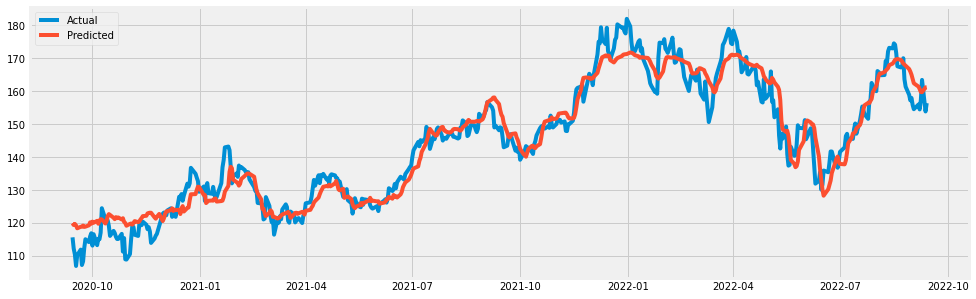

In [16]:
train_eval = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

train_df["prediction"] = predict(train_eval, model, device)
test_df["prediction"] = predict(test_loader, model, device)

df_out = pd.concat([train_df, test_df], axis=0)[[target, "prediction"]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_std + target_mean

# plot predictions
plt.figure(figsize=(15,5))
plt.plot(df_out[target], label="Actual")
plt.plot(df_out["prediction"], label="Predicted")

plt.legend()
plt.show()